# Solving problems by Searching
This notebook serves as supporting material for topics covered in Solving Problems by Searching 

## Maze Problem 
Let's see how we define a maze Problem. 

As discussed in the lecture, `Problem` class has five methods.

* `initial_state(self)` : This returns the initial state 

* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.

* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.

* `goal_test(self, state)` : Return a boolean for a given state - `True` if it is a goal state, else `False`.

* `path_cost(self, state)` : Return the cost of arriving at a state

Run the next cell to see how abstract class Problem is defined

In [1]:
class Maze():
    def __init__(self, maze_string):
        # Read the file and set the height and width of the maze
        contents = maze_string
                
        # Validate start and goal
        if contents.count("A") != 1:
            raise Exception("maze must have exactly one start point")
        if contents.count("B") != 1:
            raise Exception("maze must have exactly one goal")

        # if no cost and no comma, assign cost of 1
        if contents.count(",") == 0:
            contents = contents.replace(' ','1')
            contents = contents.splitlines()
            contents = [','.join(list(c)) for c in contents]
        else:
            contents = contents.splitlines()
            
        contents = [line.split(',') for line in contents]
        
        self.height = len(contents)
        self.width = max(len(line) for line in contents)
        
        # Keep track of walls
        self.walls = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.start = (i, j)
                        row.append(0)
                    elif contents[i][j] == "B":
                        self.goal = (i, j)
                        row.append(0)
                    elif contents[i][j].isdigit():
                        row.append(int(contents[i][j]))
                    else:
                        row.append(-1)
                except IndexError:
                    row.append(-1)
            self.walls.append(row)
            

    def initial_state(self):
        return self.start

    def goal_test(self, state):
        return state == self.goal

    def result(self, state):    
        row, col = state
        candidates = [
            ("up", (row - 1, col)),
            ("down", (row + 1, col)),
            ("left", (row, col - 1)),
            ("right", (row, col + 1))
        ]
        result = []
        for action, (r, c) in candidates:
            if 0 <= r < self.height and 0 <= c < self.width and self.walls[r][c] >=0 :
                result.append((action, (r, c)))
        return result
    def path_cost(self, state):
        return self.walls[state[0]][state[1]]
        
    def heuristic(self, state):
        return abs(state[0] - self.goal[0]) + abs(state[1] - self.goal[1]) 
        
    # for visualization    
    def output_image(self, solution = None, explored = None, show_solution=True, show_explored=False):
        from PIL import Image, ImageDraw, ImageFont
        cell_size = 50
        cell_border = 2

        # Create a blank canvas
        img = Image.new(
            "RGBA",
            (self.width * cell_size, self.height * cell_size),
            "black"
        )
        draw = ImageDraw.Draw(img)
        #font = ImageFont.truetype("arial.ttf", 48)
        
        solution = solution[1] if solution is not None else None
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):

                # Walls
                if col == -1:
                    fill = (40, 40, 40)

                # Start
                elif (i, j) == self.start:
                    fill = (255, 0, 0)
                    

                # Goal
                elif (i, j) == self.goal:
                    fill = (0, 171, 28)
        
                
                # Solution
                elif solution is not None and show_solution and (i, j) in solution:
                    fill = (220, 235, 113)
                    

                # Explored
                elif solution is not None and show_explored and (i, j) in explored:
                    fill = (212, 97, 85)        

                # Empty cell
                else:
                    fill = (237, 240, 252)
           

                # Draw cell
                draw.rectangle(
                    ([(j * cell_size + cell_border, i * cell_size + cell_border),
                      ((j + 1) * cell_size - cell_border, (i + 1) * cell_size - cell_border)]),
                    fill=fill
                )
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                if self.walls[i][j] > 0:
                    draw.text((j*cell_size+10, i*cell_size+10), str(self.walls[i][j]), (0,100,100))
                    
        display(img)
        #img.save('test.png')

We will define the maze using the string below, where ```#``` indicates walls and empty space indicates free space. A is the initial state and B is the goal state.
```
maze = "##    #\n\
## ## #\n\
#B #  #\n\
# ## ##\n\
     ##\n\
A######"
```

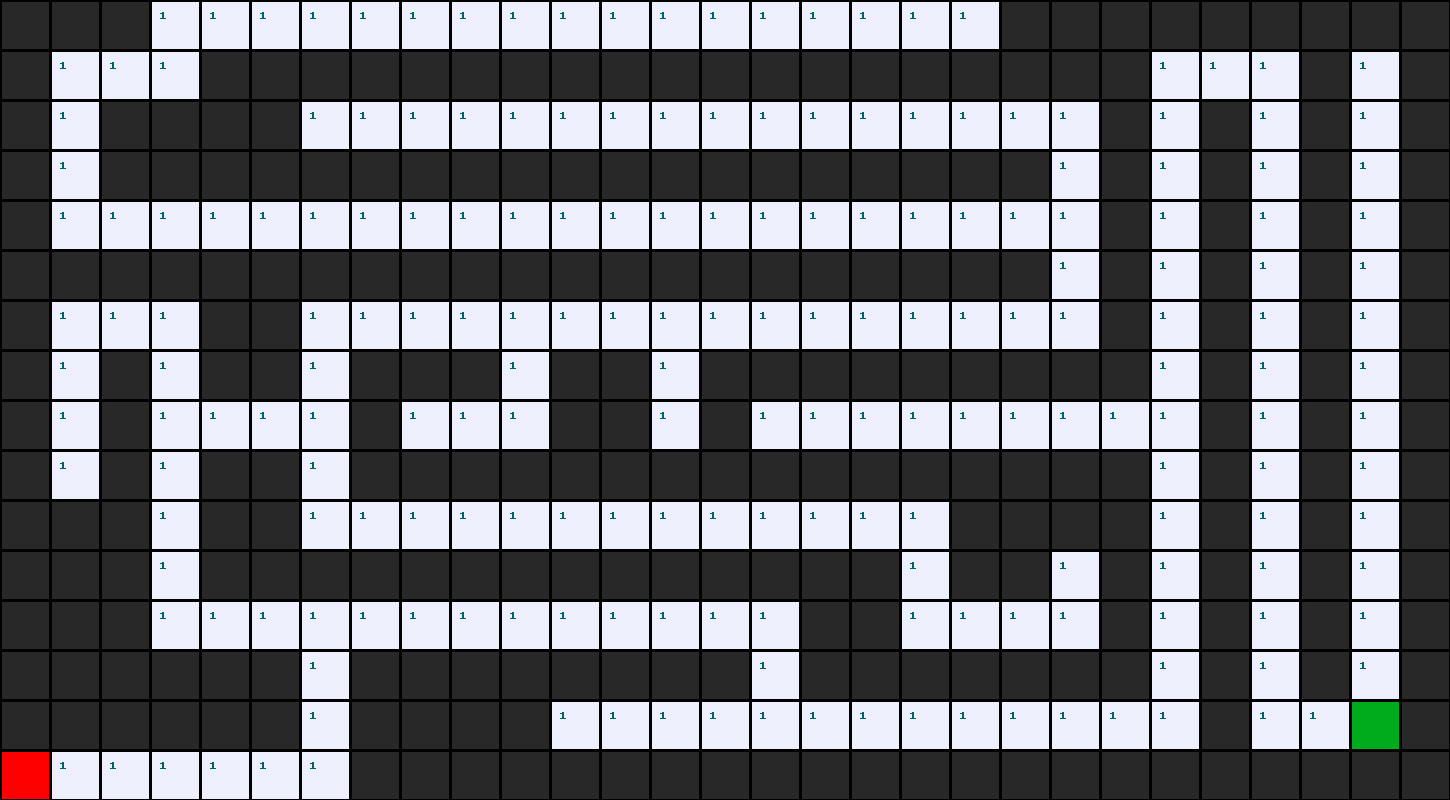

In [3]:
maze1 = "#####B#\n\
##### #\n\
####  #\n\
#### ##\n\
     ##\n\
A######"

maze2 = "###                 #########\n\
#   ###################   # #\n\
# ####                # # # #\n\
# ################### # # # #\n\
#                     # # # #\n\
##################### # # # #\n\
#   ##                # # # #\n\
# # ## ### ## ######### # # #\n\
# #    #   ## #         # # #\n\
# # ## ################ # # #\n\
### ##             #### # # #\n\
### ############## ## # # # #\n\
###             ##    # # # #\n\
###### ######## ####### # # #\n\
###### ####             #  B#\n\
A      ######################"

maze3 = "1,1,1,1,1,1,#\n\
1,#,1,#,#,B,#\n\
1,1,#,#,2,2,#\n\
#,1,#,#,2,#,#\n\
1,1,2,2,2,1,1\n\
A,#,#,#,1,1,1"

problem = Maze(maze2)
#state = problem.initial_state()
#problem.result((15,6))kkkkkn
problem.output_image()

## Node
Let's see how we define a Node. Run the next cell to see how class Node is defined. The Node class helps in constructing paths from the goal state back to the initial state. By maintaining references to parent nodes, we can traverse the path in reverse order, effectively reconstructing the sequence of actions leading to the goal state. 

In [4]:
import sys

class Node():
    def __init__(self, state, parent, action, gcost, hcost):
        self.state = state
        self.parent = parent # parent of the current node
        self.action = action # action that was taken to reach this node
        self.gcost = gcost # cost
        self.hcost = hcost # heuristic
    def __lt__(self, other):
        return self.gcost+self.hcost < other.gcost+other.hcost


In [5]:
import heapq

frontier = []
heapq.heappush(frontier, 7)
heapq.heappush(frontier, 5)
heapq.heappush(frontier, 3)

print(frontier)

heapq.heappop(frontier)

print(frontier)

[3, 7, 5]
[5, 7]


## Datastructure for Frontier

In [6]:
# Last in first out frontier
import heapq

class StackFrontier():
    def __init__(self):
        self.frontier = []

    def add(self, node):
        self.frontier.append(node)

    def contains_state(self, state):
        return any(node.state == state for node in self.frontier)

    def empty(self):
        return len(self.frontier) == 0

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier.pop()
            return node

# First in first out frontier
class QueueFrontier(StackFrontier):

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier.pop(0)
            return node

class PQueueFrontier(StackFrontier):
    def __init__(self):
        self.frontier = []

    def add(self, node):
        heapq.heappush(self.frontier, node)

    def contains_state(self, state):
        return any(node.state == state for node in self.frontier)

    def empty(self):
        return len(self.frontier) == 0

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = heapq.heappop(self.frontier)
            return node

## Graph Search Algorithm

In [7]:
def graph_search(problem, algo):
    
    # Initialize frontier to just the starting position
    start = Node(state=problem.start, parent=None, action=None, gcost=0, hcost=0)
        
    frontier = PQueueFrontier()
    frontier.add(start)
    
    # Initialize an empty explored set
    explored = set()
    
    # Keep looping until solution found
    while True:
        # If nothing left in frontier, then no path
        if frontier.empty():
            raise Exception("no solution")
        
        # Choose a node from the frontier
        node = frontier.remove()
        
        # If node is the goal, then we have a solution
        if problem.goal_test(node.state):
            actions = []
            cells = []
            while node.parent is not None:
                actions.append(node.action)
                cells.append(node.state)
                node = node.parent
            actions.reverse()
            cells.reverse()
            solution = (actions, cells)
            return solution, explored

        # Mark node as explored
        explored.add(node.state)
        # Add neighbors to frontier
        for action, state in problem.result(node.state):
            #if not frontier.contains_state(state) and state not in explored:
            if state not in explored:
                if algo == 'ucs':
                    child = Node(state=state, parent=node, action=action, gcost=node.gcost+problem.path_cost(state), hcost=0)
                elif algo == 'greedy':
                    child = Node(state=state, parent=node, action=action, gcost=0, hcost=problem.heuristic(state))
                elif algo == 'a*':
                    child = Node(state=state, parent=node, action=action, gcost=node.gcost+problem.path_cost(state), hcost=problem.heuristic(state))
                else:
                    raise Exception("Error")
                   
                frontier.add(child)

## Solution
In the figures below 
 - red is start state,
 - green is goal state,
 - yellow is the path found from start to goal state and
 - brown are the states explored

**Greedy search** is not optimal as it found a suboptimal path. 

**UCS** found the optimal path but it had to explore many states

**A\*** found the optimal path and explored less states than UCS

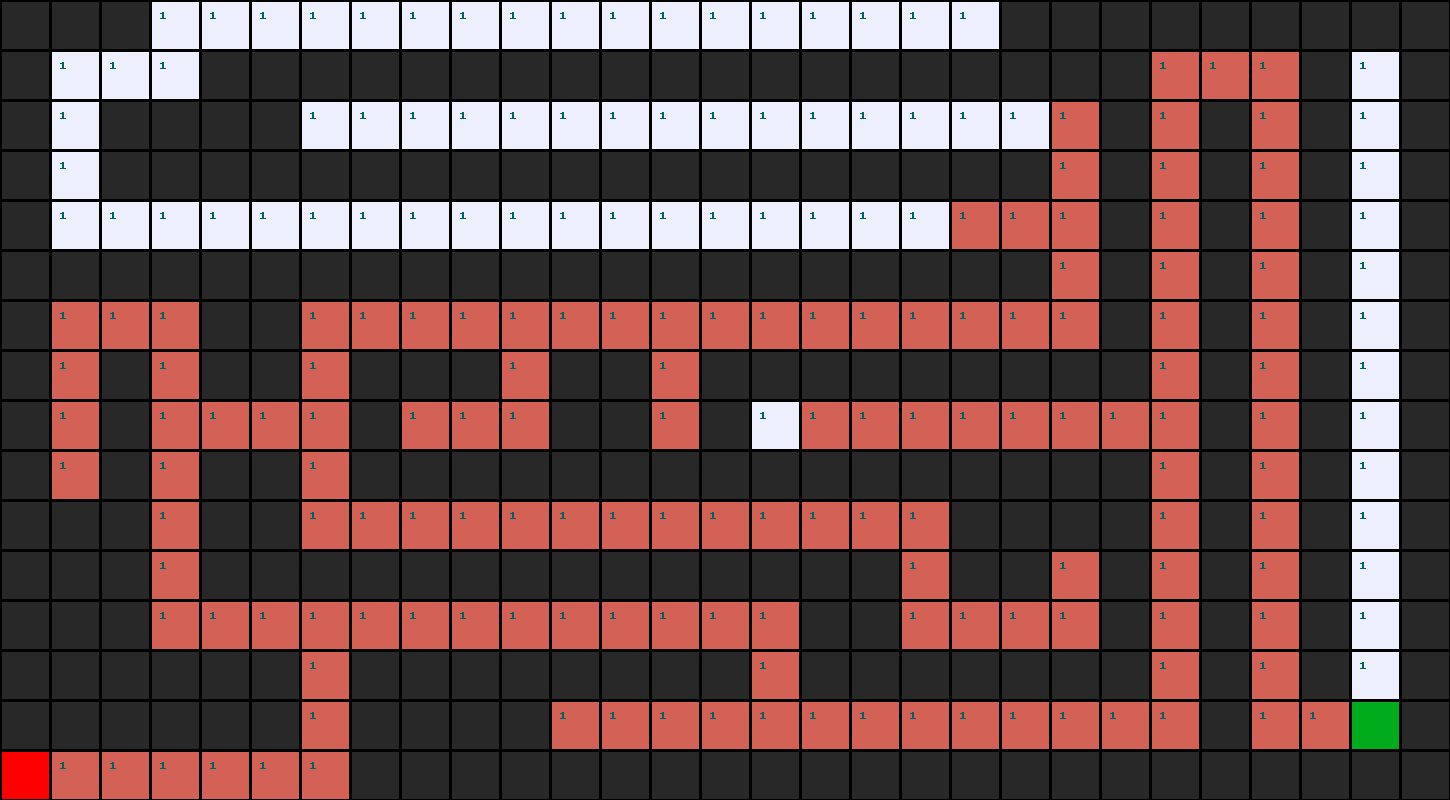

In [20]:
problem = Maze(maze2)

solution, explored = graph_search(problem, 'a*')
problem.output_image(solution=solution, explored=explored, show_solution=False, show_explored=True)

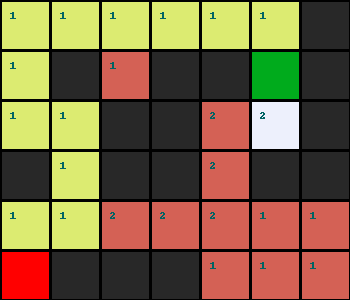

In [7]:
problem = Maze(maze3)

solution, explored = graph_search(problem, 'ucs')
problem.output_image(solution=solution, explored=explored, show_solution=True, show_explored=True)

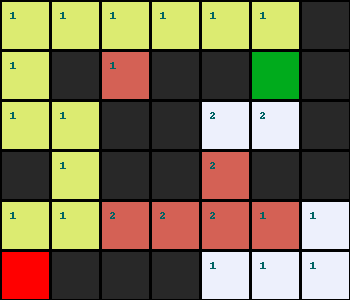

In [8]:
problem = Maze(maze3)

solution, explored = graph_search(problem, 'a*')
problem.output_image(solution=solution, explored=explored, show_solution=True, show_explored=True)